# TF interaction analysis

In [8]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pickle as pkl
%matplotlib inline
import itertools

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)

In [9]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento

In [10]:
data_path = '/data_volume/memento/tfko140/'


### Read 1D results

In [7]:
de_result = pd.read_csv(data_path + '1d/raw_1d_result.csv')

In [8]:
de_result['de_all_fdr'] = memento.util._fdrcorrect(de_result['de_pval'])

In [9]:
thresh = 0.05
condition = 'de_all_fdr < 0.1 & (de_coef < -{thresh} | de_coef > {thresh})'.format(thresh=thresh)

In [10]:
guide_de_counts = de_result.query(condition).tx.value_counts()

In [11]:
interaction_guides = guide_de_counts[guide_de_counts > 10].index.tolist()

In [12]:
interaction_guide_targets = [x.split('.')[0] for x in interaction_guides]

In [13]:
interaction_downstream_genes = de_result.query(condition + ' & tx in @interaction_guides').gene.drop_duplicates().tolist()

In [14]:
guide_de_gene_mapping = dict(de_result\
    .query(condition + ' & tx in @interaction_guides')\
    .groupby('tx').gene.apply(list))

In [15]:
len(interaction_guides)

72

In [16]:
sig_de_result = de_result.query(condition + ' & tx in @interaction_guides').copy()

In [17]:
sig_de_result['target_gene'] = sig_de_result['tx'].str.split('.').str[0]

### Read and setup memento

In [18]:
adata = sc.read(data_path + 'tfko.sng.guides.full.ct.h5ad')

Only considering the two last: ['.ct', '.h5ad'].
Only considering the two last: ['.ct', '.h5ad'].


In [19]:
adata.obs['q'] = 0.11

In [20]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1, shrinkage=0)

In [21]:
adata.obs['guide1_cov'] = adata.obs['guide1_cov'].str.split('.').str[:-1].str.join('.')

### Calculate TF-DEG correlations in WT cells

In [22]:
adata_one_sample = adata[adata.obs.WT == "T"].copy().copy()
# adata_one_sample = adata.copy().copy()

adata_one_sample.obs['all'] = 'A'
memento.create_groups(adata_one_sample, label_columns=['donor','all'])
memento.compute_1d_moments(adata_one_sample, min_perc_group=.8)


In [23]:
all_pairs = []
for guide, gene_list in guide_de_gene_mapping.items():
    
    tf = guide.split('.')[0]
    if tf not in adata_one_sample.var.index:
        continue
    all_pairs += itertools.product(
        [tf], 
        list( (set(gene_list) & set(adata_one_sample.var.index))-set([tf])))

In [24]:
memento.compute_2d_moments(adata_one_sample, all_pairs)

In [25]:
wt_corrs = memento.get_2d_moments(adata_one_sample, groupby='all')
wt_corrs = wt_corrs.merge(sig_de_result, left_on=['gene_1', 'gene_2'], right_on=['target_gene', 'gene'])

In [26]:
wt_corrs['type'] = wt_corrs['de_coef'].apply(lambda x: 'repressor' if x > 0 else 'activator')

In [27]:
wt_corrs.head(5)

,gene_1,gene_2,all_A,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,de_all_fdr,target_gene,type
0,ARID5B,HIST1H1D,-0.106776,HIST1H1D,ARID5B.62050979,-0.148790,0.040616,0.000347,0.0,2.489015e-16,1.0,0.058613,0.065221,ARID5B,activator
1,ARID5B,SELL,-0.027582,SELL,ARID5B.62050979,0.125184,0.030226,0.000051,0.0,1.528136e-16,1.0,0.017753,0.018415,ARID5B,repressor
2,ARID5B,SNRNP25,-0.176104,SNRNP25,ARID5B.62050979,-0.077010,0.022593,0.000655,0.0,2.978116e-16,1.0,0.084908,0.096022,ARID5B,activator
3,ARID5B,TPM4,0.012198,TPM4,ARID5B.62050979,-0.111101,0.027744,0.000064,0.0,2.342643e-16,1.0,0.020843,0.021816,ARID5B,activator
4,ARID5B,PDAP1,0.010422,PDAP1,ARID5B.62050979,-0.090139,0.021805,0.000037,0.0,2.535298e-16,1.0,0.015059,0.014785,ARID5B,activator


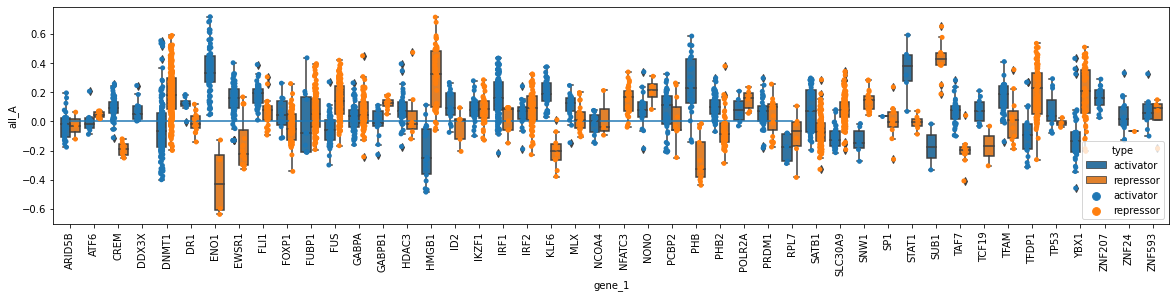

In [50]:
plt.figure(figsize=(20, 4));
sns.boxplot(y='all_A', x='gene_1', hue='type', data=wt_corrs)
sns.stripplot(y='all_A', x='gene_1', hue='type', data=wt_corrs, dodge=True, s=5)

plt.xticks(rotation=90);
plt.plot([0, 30], [0, 0])

In [51]:
# Are activators more likely to be positively correlated to its downstream genes?
num_activator_pos = (wt_corrs.query('type == "activator"').groupby('gene_1')['all_A'].mean() > 0).sum()
pv = stats.binom_test(x=num_activator_pos, n=wt_corrs.query('type == "activator"')['gene_1'].drop_duplicates().shape[0])
print('Binom test for activators having positive correlation', pv)

Binom test for activators having positive correlation 0.006608822842281368


In [52]:
# Are activators more likely to be positively correlated to its downstream genes?
num_activator_pos = (wt_corrs.query('type == "repressor"').groupby('gene_1')['all_A'].mean() < 0).sum()
pv = stats.binom_test(x=num_activator_pos, n=wt_corrs.query('type == "repressor"')['gene_1'].drop_duplicates().shape[0])
print('Binom test for activators having positive correlation', pv)

Binom test for activators having positive correlation 0.17417114727072658


In [28]:
# Attach the mean corr for each regulator to the wt_corrs DataFrame
wt_corrs = wt_corrs.merge(wt_corrs.groupby(['gene_1', 'type'])['all_A'].mean().reset_index(name='mean_corr'), on=['gene_1', 'type']).sort_values('mean_corr', ascending=False)

/tmp/ipykernel_9459/2116727482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['tf'] = pd.Categorical(to_plot['gene_1'].values, categories=to_plot['gene_1'].drop_duplicates().tolist())


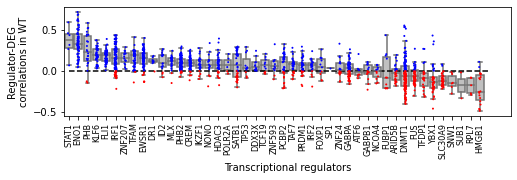

In [67]:
plt.figure(figsize=(8, 2));
to_plot = wt_corrs.query('type == "activator"')
to_plot['tf'] = pd.Categorical(to_plot['gene_1'].values, categories=to_plot['gene_1'].drop_duplicates().tolist())
sns.boxplot(y='all_A', x='tf', data=to_plot, fliersize=0, color='silver')
sns.stripplot(y='all_A', x='tf', data=to_plot.query('all_A > 0'), s=2, color='blue')
sns.stripplot(y='all_A', x='tf', data=to_plot.query('all_A < 0'), s=2, color='red')


plt.xticks(rotation=90, fontsize=8);
plt.plot([0, len(wt_corrs.query('type == "activator"').gene_1.drop_duplicates())], [0, 0], linestyle='--',color='k')
plt.xlabel('Transcriptional regulators');
plt.ylabel('Regulator-DEG\ncorrelations in WT');
plt.savefig('tf_deg_wt_corrs.pdf', bbox_inches='tight')

In [31]:
# plt.figure(figsize=(8, 2));
# sns.boxplot(y='all_A', x='gene_1', data=wt_corrs.query('type == "repressor"'), fliersize=0, color='seagreen')
# # sns.stripplot(y='all_A', x='gene_1', data=wt_corrs.query('type == "activator"'), dodge=True, s=2, color='grey')

# plt.xticks(rotation=90, fontsize=8);
# plt.plot([0, len(wt_corrs.query('type == "repressor"').gene_1.drop_duplicates())], [0, 0], linestyle='--',color='k')
# plt.xlabel('Transcriptional regulators');
# plt.ylabel('Regulator-DEG\ncorrelations in WT');
# # plt.savefig('tf_deg_wt_corrs.pdf', bbox_inches='tight')

### Run differential correlation

In [29]:
activator_wt_corrs = wt_corrs.query('type == "activator"')

In [30]:
selected_activators = activator_wt_corrs.query('mean_corr > 0.05').gene_1.value_counts().index.tolist()

In [31]:
encode_meta = pd.read_csv('encode_tf/metadata.tsv', sep='\t', header=0)
encode_files = pd.read_csv('encode_tf/files.txt', sep='\t', header=None)

encode_meta = encode_meta[encode_meta['Output type'].isin([ 'IDR thresholded peaks', 'optimal IDR thresholded peaks']) & (encode_meta['File assembly'] == 'GRCh38')]
encode_meta['target'] = encode_meta['Experiment target'].str.split('-').str[0]
encode_meta = encode_meta.sort_values('Output type', ascending=False).drop_duplicates('target')#.query('target in @selected_activators')
encode_meta = encode_meta[encode_meta['Audit ERROR'].isnull()]
encode_tfs = encode_meta.target.tolist()

In [32]:
selected_activators = [g for g in selected_activators if g in encode_tfs]
selected_interaction_guides = [g for g in interaction_guides if g.split('.')[0] in encode_tfs]

In [33]:
selected_activator_wt_corrs = activator_wt_corrs.query('gene_1 in @selected_activators')

In [220]:
adata_ko = adata.copy().copy()

memento.create_groups(adata_ko, label_columns=['guide1_cov'])
memento.compute_1d_moments(adata_ko, min_perc_group=.7)
meta_df = memento.get_groups(adata_ko)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=False)

treatment = meta_df[selected_interaction_guides]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])
# covariate = meta_df.iloc[:, -9:]


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [221]:
tf_deg_pairs = [
    (a, b) for a, b in zip(selected_activator_wt_corrs.query('all_A > 0.1')['gene_1'], selected_activator_wt_corrs.query('all_A > 0.1')['gene_2'])]
tf_deg_pairs = [(a,b) for a, b in tf_deg_pairs if a in adata_ko.var.index and b in adata_ko.var.index]

In [ ]:
memento.compute_2d_moments(adata_ko, tf_deg_pairs)

#2:49 start
memento.ht_2d_moments(
        adata_ko, 
        covariate=covariate,
        treatment=treatment,
        num_boot=10000, 
        verbose=1,
        num_cpus=90,
        resampling='bootstrap',
        resample_rep=False,
        approx=True)
adata_ko.write(data_path + 'activator_interaction.h5ad')

[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done  20 tasks      | elapsed:  1.2min


In [5]:
adata_ko = sc.read(data_path + 'activator_interaction.h5ad')

In [6]:
df = memento.get_2d_ht_result(adata_ko).drop_duplicates(['gene_1', 'gene_2', 'tx'])

In [7]:
df['corr_fdr'] = df.groupby('tx')['corr_pval'].transform(memento.util._fdrcorrect)

In [14]:
df.query('corr_fdr < 0.1').to_csv(data_path + '../tables/Supplementary_Table_4_Perturb-seq_DC.csv', index=False)

In [39]:
df.query('corr_fdr < 0.1 & corr_coef < 0')#[['gene_1', 'tx']].drop_duplicates()

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,corr_fdr
202,STAT1,PSME1,IRF1.132487119,-0.295674,0.064251,1.445888e-05,5.017233e-03
237,PHB,TMSB4X,FUS.31183999,-0.228128,0.073842,2.040532e-03,7.039834e-02
425,PHB,TPX2,FUS.31183999,-0.191595,0.057375,1.097695e-03,5.017433e-02
1378,KLF6,ANXA1,IKZF1.50376659,-0.399312,0.073741,6.737734e-08,2.344731e-05
2100,KLF6,MYL12B,FUBP1.77969992,-0.275314,0.063591,6.207890e-05,2.166554e-02
2437,KLF6,IQGAP1,PCBP2.53459399,-0.468409,0.104813,3.374887e-05,1.167711e-02
2587,KLF6,TXN,FUS.31183999,-0.172183,0.053791,3.170896e-03,9.116327e-02
2893,IRF1,LGALS3BP,PRDM1.106088300,-0.382776,0.081740,2.995733e-06,1.042515e-03
2940,IRF1,PARP14,PRDM1.106088300,-0.354060,0.099250,3.605966e-04,4.182921e-02
5219,IRF1,APOL1,FUS.31183999,-0.371833,0.068353,6.078638e-08,2.097130e-05


### Combine with ENCODE data

In [40]:
encode_df = pd.read_csv(data_path + 'encode_result.csv')

In [41]:
df['target_gene'] = df['tx'].str.split('.').str[0]

In [42]:
encode_dc_result = df.query('target_gene != gene_1')\
    .merge(encode_df, left_on=['gene_1', 'gene_2'], right_on=['tf', 'gene'])\
    .drop('gene', axis=1)\
    .merge(encode_df, left_on=['target_gene', 'gene_2'], right_on=['tf', 'gene'], suffixes=('_tf', '_ko'))\
    .drop('gene', axis=1)

In [47]:
wt_corrs.query('gene_1 =="IRF1" & gene_2=="LGALS3BP"')

,gene_1,gene_2,all_A,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,de_all_fdr,target_gene,type,mean_corr
1617,IRF1,LGALS3BP,0.277741,LGALS3BP,IRF1.132487047,-0.052381,0.012727,0.000048,0.0,2.266311e-16,1.0,0.009359,0.017715,IRF1,activator,0.17576


In [43]:
de_result.query('gene == "LGALS3BP" & tx == "PRDM1.106088300"')

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,de_all_fdr
613387,LGALS3BP,PRDM1.106088300,-0.050116,0.013914,0.000715,0.0,2.373052e-16,1.0,0.097837,0.100581


In [44]:
encode_dc_result.query('corr_fdr < 0.1')#[['distance_tf', 'distance_ko']]#.mean()

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,corr_fdr,target_gene,distance_tf,tf_tf,distance_ko,tf_ko
323,PHB,TMSB4X,FUS.31183999,-0.228128,0.073842,2.040532e-03,0.070398,FUS,9158832,PHB,3810637,FUS
547,PHB,TPX2,FUS.31183999,-0.191595,0.057375,1.097695e-03,0.050174,FUS,208,PHB,15346,FUS
1475,KLF6,ANXA1,IKZF1.50376659,-0.399312,0.073741,6.737734e-08,0.000023,IKZF1,1196865,KLF6,1021,IKZF1
2241,KLF6,MYL12B,FUBP1.77969992,-0.275314,0.063591,6.207890e-05,0.021666,FUBP1,0,KLF6,202518,FUBP1
2670,KLF6,IQGAP1,PCBP2.53459399,-0.468409,0.104813,3.374887e-05,0.011677,PCBP2,280,KLF6,150264,PCBP2
2783,KLF6,TXN,FUS.31183999,-0.172183,0.053791,3.170896e-03,0.091163,FUS,235,KLF6,1374765,FUS
3022,CREM,LGALS1,PRDM1.106088300,0.346794,0.087525,2.467032e-04,0.041829,PRDM1,54,CREM,12230,PRDM1
3058,IRF1,LGALS3BP,FUS.31183999,0.666627,0.185892,2.759706e-03,0.086554,FUS,0,IRF1,133504,FUS
3083,IRF1,LGALS3BP,PRDM1.106088300,-0.382776,0.081740,2.995733e-06,0.001043,PRDM1,0,IRF1,0,PRDM1
3128,IRF1,PARP14,PRDM1.106088300,-0.354060,0.099250,3.605966e-04,0.041829,PRDM1,0,IRF1,70518,PRDM1


In [297]:
dist = 1000
encode_dc_result['sig'] = encode_dc_result['corr_fdr'] < 0.5
hits_tf = encode_dc_result.query('sig').gene_1.drop_duplicates().tolist()
hits_ko = encode_dc_result.query('sig').tx.drop_duplicates().tolist()

validation_df = encode_dc_result.query('gene_1 in @hits_tf & tx in @hits_ko').copy()
validation_df['both_tfbs'] = (validation_df['distance_tf'] < dist) & (validation_df['distance_ko'] < dist)
validation_df['tfbs_distance'] = (validation_df['distance_tf'] - validation_df['distance_ko']).abs()

<AxesSubplot:xlabel='sig', ylabel='both_tfbs'>

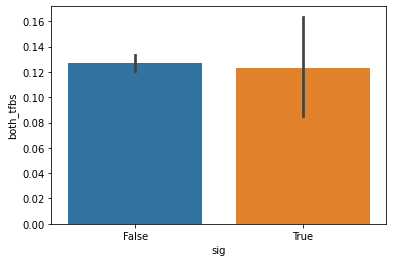

In [298]:
sns.barplot(x='sig', y='both_tfbs', data=validation_df)

### Calculate TF-DEG correlations in matched KOs

Measuring correlation between the TF and downstream genes when the TF is KO'ed is meaningless.

In [26]:
adata_ko = adata[adata.obs.guide1_cov.isin(interaction_guides)].copy().copy()
# adata_ko = adata.copy().copy()

memento.create_groups(adata_ko, label_columns=['guide1_cov', 'donor'])
memento.compute_1d_moments(adata_ko, min_perc_group=.7)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [27]:
all_ko_pairs = [(x,y) for x,y in all_pairs if x in adata_ko.var.index and y in adata_ko.var.index]

In [28]:
memento.compute_2d_moments(adata_ko, all_ko_pairs)

In [ ]:
ko_corrs = memento.get_2d_moments(adata_ko, groupby='guide1_cov')
ko_corrs = ko_corrs.merge(sig_de_result, left_on=['gene_1', 'gene_2'], right_on=['target_gene', 'gene'])

In [30]:
ko_corrs['type'] = ko_corrs['de_coef'].apply(lambda x: 'repressor' if x > 0 else 'activator')

In [31]:
def get_matched_column(row):
    
    tf = row['gene_1']
    for col in row.keys():
        
        if tf in col:
            return row[col]

In [32]:
ko_corrs['matched_ko_corr'] = ko_corrs.apply(get_matched_column, axis=1)

In [33]:
a = ko_corrs[['gene_1', 'gene_2', 'matched_ko_corr', 'type']].copy().rename(columns={'matched_ko_corr':'all_A'})
b = wt_corrs[['gene_1', 'gene_2', 'all_A', 'type']].copy()
a['ko'] = 'ko'
b['ko'] = 'wt'
all_corrs = pd.concat([a,b])

In [35]:
all_corrs['classification'] = all_corrs['type'] + '-' + all_corrs['ko']

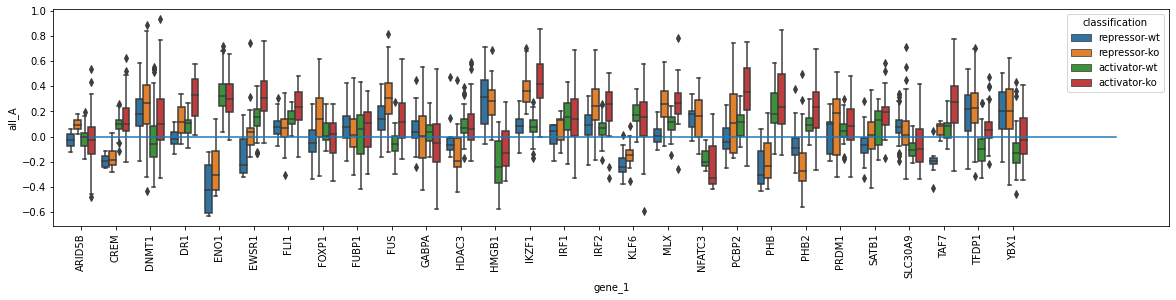

In [41]:
plt.figure(figsize=(20, 4));
sns.boxplot(y='all_A', x='gene_1', hue='classification', data=all_corrs.sort_values(['type', 'ko'], ascending=False))
# sns.stripplot(y='all_A', x='gene_1', hue='classification', data=all_corrs, dodge=True)

plt.xticks(rotation=90);
plt.plot([0, 30], [0, 0])

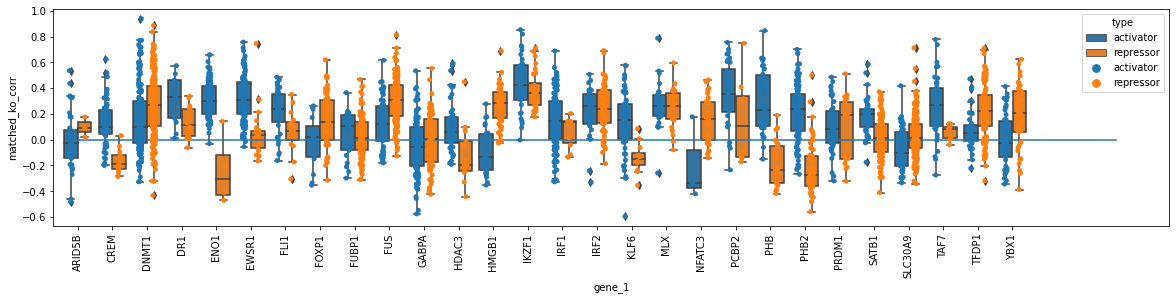

In [94]:
plt.figure(figsize=(20, 4));
sns.boxplot(y='matched_ko_corr', x='gene_1', hue='type', data=ko_corrs)
sns.stripplot(y='matched_ko_corr', x='gene_1', hue='type', data=ko_corrs, dodge=True)

plt.xticks(rotation=90);
plt.plot([0, 30], [0, 0])

In [304]:
x = adata[:, 'IRF1'].X.todense().A1+1
y = adata[:, 'LGALS3BP'].X.todense().A1

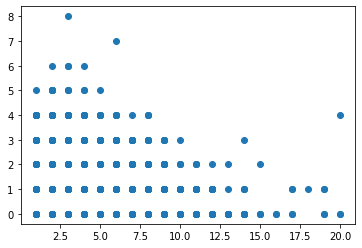

In [305]:
plt.scatter(x,y)